## Supervisor multiagent workflow

### Configure the model

In [2]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="deepseek-r1-distill-llama-70b")

### Initialize Tavily tool for search

In [3]:
from langchain_community.tools import TavilySearchResults

search_tool = TavilySearchResults()
search_tool.invoke("What is the capital of France?")

C:\Users\aayushisharma\AppData\Local\Temp\ipykernel_22936\256624651.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults()


[{'title': 'Paris facts: the capital of France in history',
  'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
  'content': 'page 4\n\n===============\n\nHomeSpainSydneySan FranciscoParisLas VegasMaui\n\n Paris, France\n\nImage 1\n\nParis facts: Paris, the capital of France\n---------------------------------------------\n\nParis is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants).\n\nParis has 2.234 million inhabitants end 2011. She is the core of Ile de France region (12 million people). [...] Before Paris, the capital of France was Lyon (under the Romans). Paris first became the capital of France in 508 under King Clovis. After centuries with no unique capital of France, Paris retrieved its status of capital of France under King Philippe Auguste, who reigned between 1180 and 1223. You can see remains of the Philippe August Paris walls in the passageway between the Louvre parking and Louvre Museum [...] Paris remained the capital

### Initialize Python repl tool

In [ ]:
from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

my_code = """
x=10
y=x+10
print(y)
"""

repl.run(my_code)

Python REPL can execute arbitrary code. Use with caution.


'20\n'

In [5]:
from langchain_core.tools import tool
from typing import Annotated

@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""

    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

python_repl_tool.invoke("x=10\ny=x+10\nprint(y)")

'Successfully executed:\n\\`\\`\\`python\nx=10\ny=x+10\nprint(y)\n\\`\\`\\`\nStdout: 20\n'

### Creating Supervisor Agent

In [6]:
from langgraph.types import Command
from langgraph.graph import START, MessagesState, StateGraph, END
from typing_extensions import TypedDict
from typing import Literal

class State(MessagesState):
    next: str

    # This is how messagestate will looklike
    # state={"messages": ["hi"], "next": "research_agent"}


# There is no routing logic. it is simply going to return the next candidate(next_agent)
# this next is containing the next candidate name
class Router(TypedDict):
    next: Literal['researcher', 'coder', 'FINISH']


def supervisor_agent(state: State) -> Command[Literal['researcher', 'coder', '__end__']]:
    members=["researcher","coder"]
    system_prompt = f""""
    You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
    Given the following user request, respond with the worker to act next. 
    Each worker will perform a task and respond with their results and status. 
    When finished, respond with FINISH.
    """

    messages = [{"role": "system", "content": system_prompt},] + state["messages"]

    llm_with_structured_output = llm.with_structured_output(Router)
    response = llm_with_structured_output.invoke(messages)

    #this is my response {'next': 'researcher'}

    #this is my next worker agent
    goto = response["next"]

    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    
    if goto == "FINISH":
        goto=END

    # class State(MessagesState):
    #   next:str
    # output of the state: state={"messages": ["hi"], "next": "researcher"}

    return Command(goto=goto, update={"next":goto})

### Research Agent

In [7]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage

def reserach_agent(state:State) -> Command[Literal["supervisor"]]:
    reserach_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math.")
    result = reserach_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

### Coder Agent

In [8]:
def coder_agent(state:State)->Command[Literal['supervisor']]:
    code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")
    result=code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )
    

### Workflow

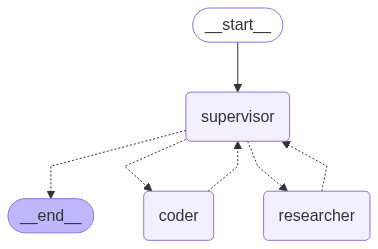

In [9]:
graph = StateGraph(State)
graph.add_node("supervisor", supervisor_agent)
graph.add_node("researcher", reserach_agent)
graph.add_node("coder", coder_agent)
graph.set_entry_point("supervisor")
app=graph.compile()

from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
researcher
((), {'supervisor': {'next': 'researcher'}})
**********BELOW IS MY STATE***************
(('researcher:3e36ff69-7d72-7538-dc65-0683edfdc016',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '01x3rj96z', 'function': {'arguments': '{"query":"square root of 42"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 283, 'prompt_tokens': 179, 'total_tokens': 462, 'completion_time': 1.21361698, 'prompt_time': 0.011320653, 'queue_time': 0.055412977, 'total_time': 1.224937633}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--738d856b-0c02-482e-9c3c-fc90a4fc0b63-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'square root of 42'}, 'id': '01x3rj96z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 179, 'output_t

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '\n\nThe square root of 42 is approximately 6.48. This value, when squared, equals 42, making it the correct square root.'}}